In [90]:
# import external libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, KFold

#Local PY files
from cleaning_functions import *
from eda import *
from random_lumberjacks.src.random_lumberjacks.model.model_classes import *
from random_lumberjacks.src.random_lumberjacks.visualization.visualization_functions import *


# Configure matplotlib for jupyter.
%matplotlib inline

In [91]:
#Imports the dataframes
dffo = pd.read_csv("data/submission_format.csv")
dftr = pd.read_csv("data/training_set_features.csv")
dfte = pd.read_csv("data/test_set_features.csv")
dfla = pd.read_csv("data/training_set_labels.csv")

df = pd.merge(dftr, dfla, on="respondent_id")
df = df.set_index("respondent_id")

In [92]:
#Cleaning steps to do before column names are established.
df = initial_cleaning(df)

#Lists of columns to be fed into the model processor object and the functions that
#manage imputed values for the nans.
binary_columns = ['behavioral_antiviral_meds',
       'behavioral_avoidance', 'behavioral_face_mask', 'behavioral_wash_hands',
       'behavioral_large_gatherings', 'behavioral_outside_home',
       'behavioral_touch_face', 'doctor_recc_h1n1', 'doctor_recc_seasonal',
       'chronic_med_condition', 'child_under_6_months', 'health_worker',
       'health_insurance', 'homeowner']
ordinal_columns = ['h1n1_concern', 'h1n1_knowledge', 'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk',
       'opinion_h1n1_sick_from_vacc', 'opinion_seas_vacc_effective',
       'opinion_seas_risk', 'opinion_seas_sick_from_vacc']
continuous_columns = ["household_adults", "household_children"]

#Function to generate a dictionary that manages impute strategies depending on
#the type of data.
impute_dict = gen_impute_dict(binary_columns, ordinal_columns, continuous_columns)

#Cleans the rest of the data and stores the fitted imputer objects into a list for later use.
df, imputes = fit_clean_data(df, impute_dict)

In [93]:
palette = independant_palette("#ee823e", "#102ca8")

In [104]:
#Creating column selection dictionaries for the data from lists of column names.

#Lists to go in the dictionaries.

missing_dummies = extract_column_names(df, "^missing")
target_col1 = "h1n1_vaccine"
target_col2 = "seasonal_vaccine"
target_cols = [target_col1, target_col2]

#The dicts that come into the arguments.
continuous = {}

categorical = {
    "nominal_features":['education', "sex"],
}
polynomial = {"method":"all", "columns":[]}

In [105]:
data = DataPreprocessor(df, target_col2, categorical, continuous, polynomial, True, True,random_state=124)
data.data_preprocessing(balance_class=False, scale_type=None, poly_degree=2)
masked_cols = data.get_X_train().columns.drop(extract_column_names(data.get_X_train(), "\^\d"))

Creating Dummies
Getting polynomial features of degree 2

['education_< 12 Years education_College Graduate', 'education_< 12 Years education_Some College', 'education_College Graduate education_Some College']
were removed for containing 0 values

Skipping class imbalance functions
No scaling specified
Skipping scaling


<Figure size 1440x1080 with 0 Axes>

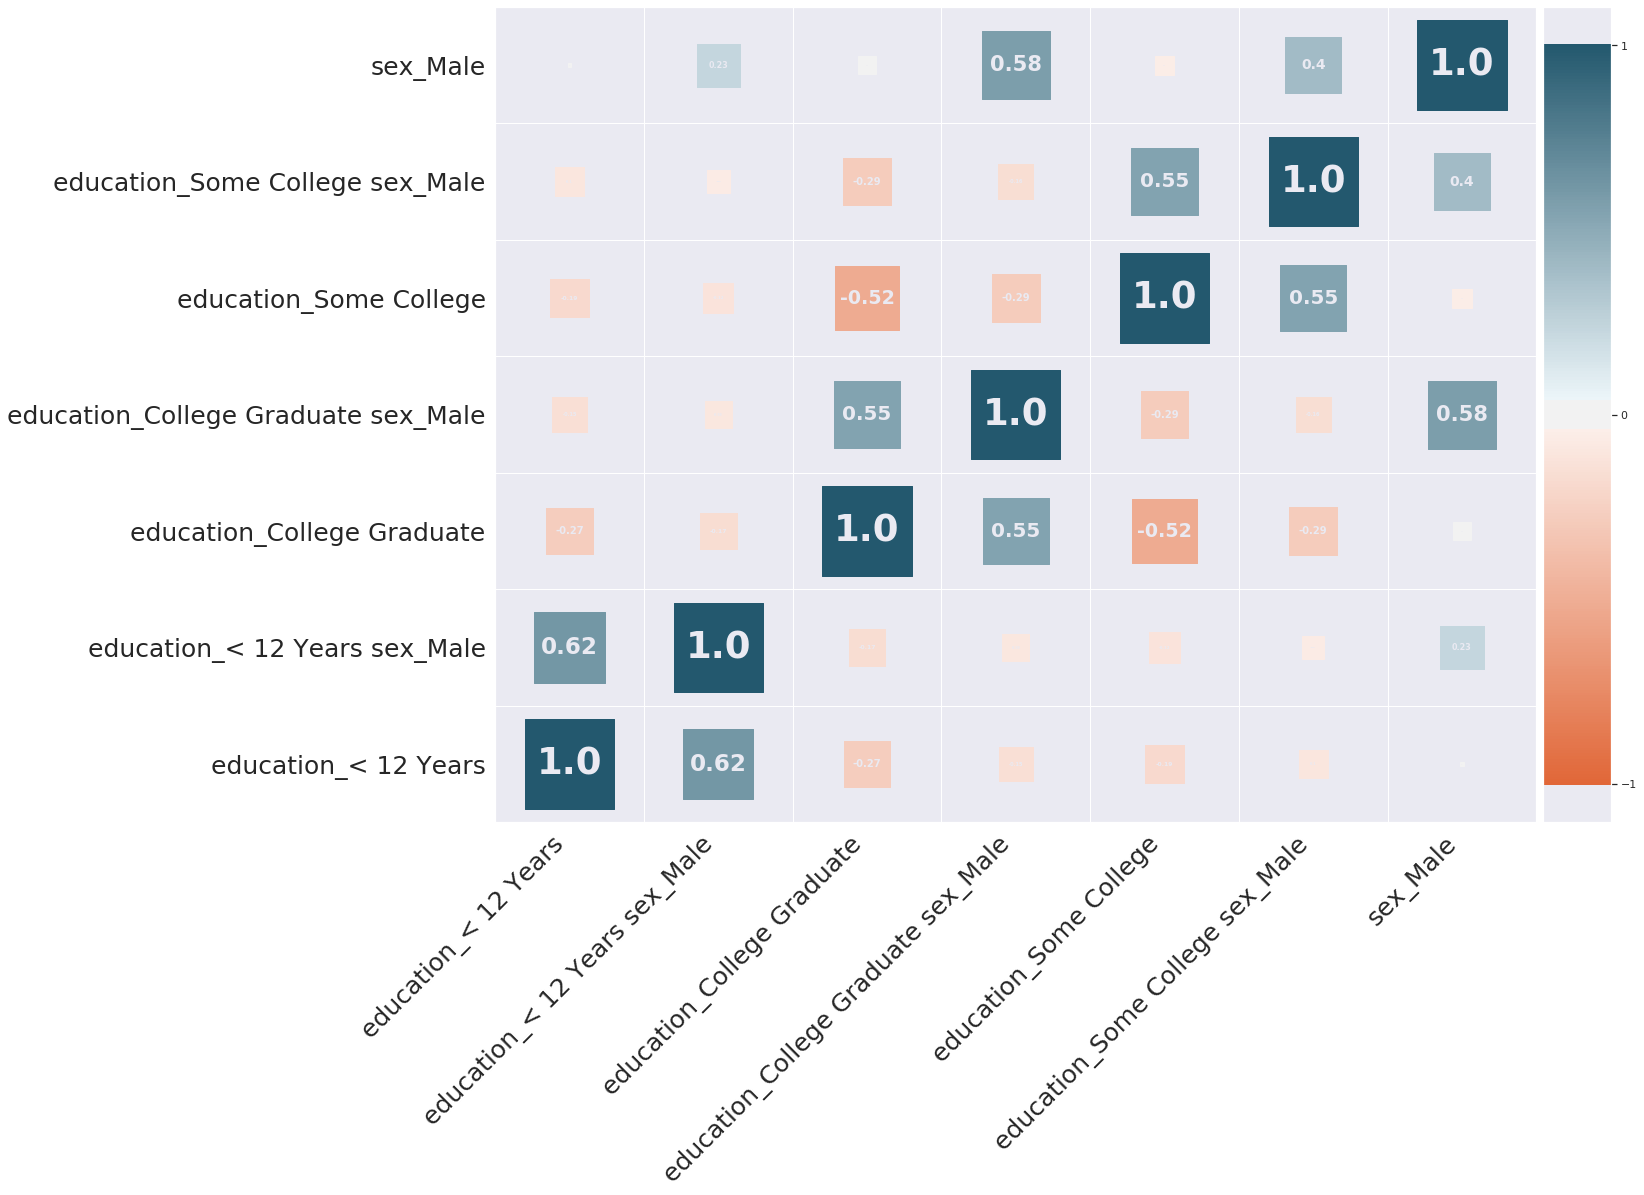

In [106]:
dynamic_heatmap(data.get_df(), masked_cols, fontsize=25, annot=1.5,
                figsize=(20,15), squaresize=8000, palette=palette)

Creating Dummies
Getting polynomial features of degree 2

['education_< 12 Years education_College Graduate', 'education_< 12 Years education_Some College', 'education_College Graduate education_Some College', 'employment_status_Not in Labor Force employment_status_Unemployed']
were removed for containing 0 values

Skipping class imbalance functions
No scaling specified
Skipping scaling


<Figure size 1440x1080 with 0 Axes>

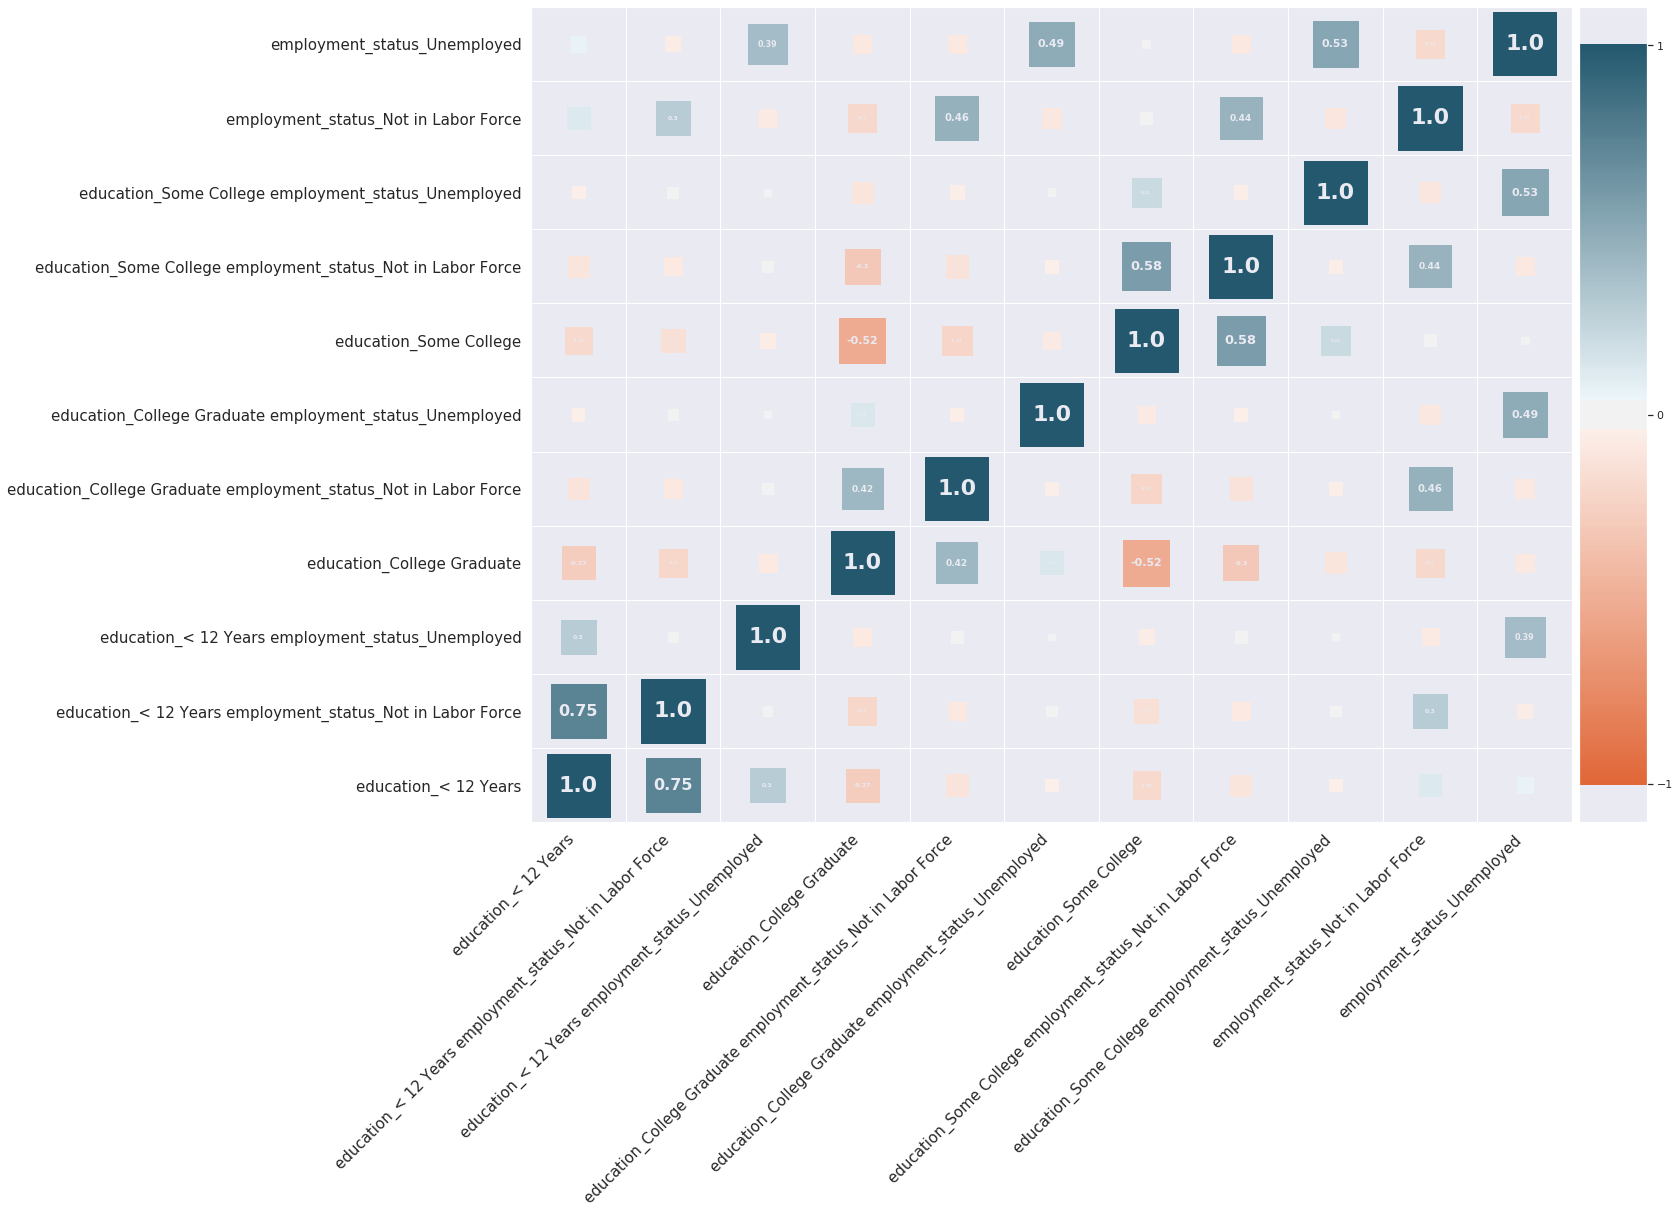

In [107]:
categorical = {
    "nominal_features":['education', "employment_status"],
}
data = DataPreprocessor(df, target_col2, categorical, continuous, polynomial, True, True,random_state=124)
data.data_preprocessing(balance_class=False, scale_type=None, poly_degree=2)
masked_cols = data.get_X_train().columns.drop(extract_column_names(data.get_X_train(), "\^\d"))
dynamic_heatmap(data.get_df(), masked_cols, fontsize=15, annot=1.5,
                figsize=(20,15), squaresize=4000, palette=palette)

In [63]:
categorical = {
    "nominal_features":['age_group', 'income_poverty', 'education', "race", "sex"],
    "standard_dummies":['opinion_seas_vacc_effective', 'doctor_recc_seasonal', 'opinion_seas_risk']
}

In [64]:
data = DataPreprocessor(df, target_col2, categorical, continuous, polynomial, True, True,random_state=124)
data.data_preprocessing(balance_class=False, scale_type=None, poly_degree=2)
masked_cols = data.get_X_train().columns.drop(extract_column_names(data.get_X_train(), "\^\d"))

Creating Dummies
Getting polynomial features of degree 2

['age_group_35 - 44 Years age_group_45 - 54 Years', 'age_group_35 - 44 Years age_group_55 - 64 Years', 'age_group_35 - 44 Years age_group_65+ Years', 'age_group_45 - 54 Years age_group_55 - 64 Years', 'age_group_45 - 54 Years age_group_65+ Years', 'age_group_55 - 64 Years age_group_65+ Years', 'income_poverty_Above Poverty income_poverty_Below Poverty', 'income_poverty_Above Poverty income_poverty_unknown', 'income_poverty_Below Poverty income_poverty_unknown', 'education_< 12 Years education_College Graduate', 'education_< 12 Years education_Some College', 'education_College Graduate education_Some College', 'race_Hispanic race_Other or Multiple', 'race_Hispanic race_White', 'race_Other or Multiple race_White']
were removed for containing 0 values

Skipping class imbalance functions
No scaling specified
Skipping scaling


In [65]:
squared_cols = extract_column_names(data.get_X_train(), "\^\d")
masked_cols = data.get_X_train().columns.drop(squared_cols)

corr_cols=correlated_columns_by_threshold(data.get_X_train(), masked_cols, .55)
poly_corr_cols = np.intersect1d(corr_cols, data.cols_polynomial)
data.cols_polynomial.drop([*poly_corr_cols, *squared_cols])
to_drop = np.intersect1d(data.cols_polynomial, [*poly_corr_cols, *squared_cols])
data.column_drop(to_drop)

Adding ['opinion_seas_vacc_effective^2', 'opinion_seas_vacc_effective doctor_recc_seasonal', 'opinion_seas_vacc_effective opinion_seas_risk', 'opinion_seas_vacc_effective age_group_35 - 44 Years', 'opinion_seas_vacc_effective age_group_45 - 54 Years', 'opinion_seas_vacc_effective age_group_55 - 64 Years', 'opinion_seas_vacc_effective age_group_65+ Years', 'opinion_seas_vacc_effective income_poverty_Above Poverty', 'opinion_seas_vacc_effective income_poverty_Below Poverty', 'opinion_seas_vacc_effective income_poverty_unknown', 'opinion_seas_vacc_effective education_< 12 Years', 'opinion_seas_vacc_effective education_College Graduate', 'opinion_seas_vacc_effective education_Some College', 'opinion_seas_vacc_effective race_Hispanic', 'opinion_seas_vacc_effective race_Other or Multiple', 'opinion_seas_vacc_effective race_White', 'opinion_seas_vacc_effective sex_Male', 'doctor_recc_seasonal^2', 'doctor_recc_seasonal opinion_seas_risk', 'doctor_recc_seasonal age_group_55 - 64 Years', 'doctor

In [66]:
test_df = data.get_df()[data.get_df().columns.drop(data.cols_initial).union(["seasonal_vaccine"])]

In [89]:
thresh = df_test_threshhold(test_df.corr().tail().T, "seasonal_vaccine", .1)
test_df.corr().tail().T.iloc[:,4][thresh].index.drop("seasonal_vaccine")

Index(['age_group_65+ Years education_College Graduate',
       'age_group_65+ Years sex_Male',
       'doctor_recc_seasonal age_group_45 - 54 Years',
       'doctor_recc_seasonal education_Some College',
       'doctor_recc_seasonal income_poverty_unknown',
       'doctor_recc_seasonal sex_Male'],
      dtype='object')

In [68]:
data.get_df()[data.cols_initial.union(["seasonal_vaccine"])].corr().tail().T.iloc[:,3]

age_group_35 - 44 Years        -0.084788
age_group_45 - 54 Years        -0.063682
age_group_55 - 64 Years         0.046918
age_group_65+ Years             0.244830
doctor_recc_seasonal            0.360696
education_< 12 Years           -0.040238
education_College Graduate      0.053002
education_Some College         -0.016401
income_poverty_Above Poverty    0.021327
income_poverty_Below Poverty   -0.069194
income_poverty_unknown         -0.015425
opinion_seas_risk               0.386916
opinion_seas_vacc_effective     0.358869
race_Hispanic                  -0.066995
race_Other or Multiple         -0.023186
race_White                      0.100314
seasonal_vaccine                1.000000
sex_Male                       -0.077091
Name: seasonal_vaccine, dtype: float64